# Part 4: Error analysis and model selection

In this section, I will be looking at the error analysis and finalize the selection of the model.

In [55]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.metrics import mean_squared_error

In [2]:
# Importing datasets
predictions1 = pd.read_csv('../data/predicted_value.csv')
predictions2 = pd.read_csv('../data/rnn_predicted_values.csv')
summary = pd.read_csv('../data/summary_table2.csv')

In [3]:
summary

,Model,Univariate / Multivariate,MSE,Success %
0,ARIMA,Univariate,1.707664e+08,43.3
1,Linear Regression,Univariate,8.610584e+07,83.5
2,Linear Regression,Multivariate,6.277761e+08,100.0
3,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
4,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
5,SARIMA,Univariate,1.511497e+08,50.5
6,RNN - LSTM,Univariate,1.513375e+07,40.5
7,RNN - GRU,Univariate,7.453959e+06,75.9
8,RNN - GRU 1,Multivariate,8.823056e+06,20.3
9,RNN - GRU 2,Multivariate,1.914502e+07,5.1


Looking at the summary of the models, it is easy to select from MSE. However, as the success rates are varied, it is hard to decide which model gave the best overall performance. 

One method to is to ensure that all the success rates are approximately the same. By adding a blanket increment across all the predictions to a model, I will be able raise the success rate of the model. I have decided on an arbitary success rate of 90% to compare across all models.

In [5]:
predictions1

,premium,arima_prediction,LR_prediction,LR2_prediction,LR_lasso_prediction,LR_ridge_prediction,sarima
0,38510.0,36973.069082,35261.761430,59468.877307,59428.305855,59421.111810,37501.079337
1,38941.0,37531.802645,37976.419241,63731.252825,63629.527089,63596.535593,37695.429140
2,38001.0,37075.139259,37997.141820,62205.019922,62114.592957,62084.367498,36091.692690
3,36426.0,37112.638537,37852.083769,63054.139799,62953.126568,62920.001840,34009.095681
4,34110.0,37300.409720,37748.470875,63508.140858,63403.870218,63370.192926,35692.918409
...,...,...,...,...,...,...,...
92,63000.0,32352.617001,56606.017499,102355.546378,102453.053244,102455.268294,33880.996720
93,68501.0,32315.851255,56709.630392,103824.163085,103941.579941,103952.834847,33110.258191
94,71556.0,32319.609842,56460.959448,103708.287040,103826.827722,103838.986591,33257.284965
95,72996.0,32349.768282,56606.017499,104752.614204,104808.951735,104797.619709,32961.559393


In [6]:
# Separating the df for the 2 linear regression models
lr_pred = predictions1[['premium', 'LR_prediction']]
lr2_pred = predictions1[['premium', 'LR2_prediction']]                     

In [7]:
# Creating a function to find out the increment to add to increase the success rate
def success_with_addition(actual_premium, predicted_premium, success_rate):
    current_rate = 0
    addition = 0
    while current_rate < success_rate:
        successful_bids = []
        new_preds = predicted_premium + addition
        for i in range(len(new_preds)):
            if new_preds[i] >= actual_premium[i]:
                successful_bids.append(new_preds[i])
        current_rate = (len(successful_bids) / len(actual_premium))
        addition += 1
    return addition, current_rate

In [9]:
# Creating a function to plot the new predictions using the increment
def plot_new_pred(df, actual_premium, predicted_premium, success_rate):
    addition, current_rate = success_with_addition(actual_premium, predicted_premium, success_rate)
    df['added_premium'] = predicted_premium + addition
    success_pct = round(current_rate * 100,1)
    print(f'You should add ${addition} to your predictions to achieve a {success_pct}% accuracy')
    plt.figure(figsize=(10,7))
    plt.plot(actual_premium, label='Actual')
    plt.plot(predicted_premium, label='Predicted')
    plt.plot(df['added_premium'], label='Additional price')
    plt.title('Predicted vs Actual vs Addition', fontsize=14)
    plt.legend();

In [10]:
# Creating a function to calculate difference and the std of the predictions.
def difference_table(df, col_actual, col_predict):
    df['difference'] = df[col_predict] - df[col_actual]
    df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)
    df.loc[df['success'] == 1].describe()
    new_df = df.loc[df['success'] == 1].describe().T
    a, b = round(new_df.iloc[3,1:2].values[0], 1), round(new_df.iloc[3,2:3].values[0], 1)
    return a, b

## Linear Regression Model

In [11]:
# Calculating the increment to add to the predictions.
success_with_addition(lr_pred['premium'], lr_pred['LR_prediction'], 0.90)

(1190, 0.9072164948453608)

You should add $1190 to your predictions to achieve a 90.7% accuracy


/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2343468246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['added_premium'] = predicted_premium + addition


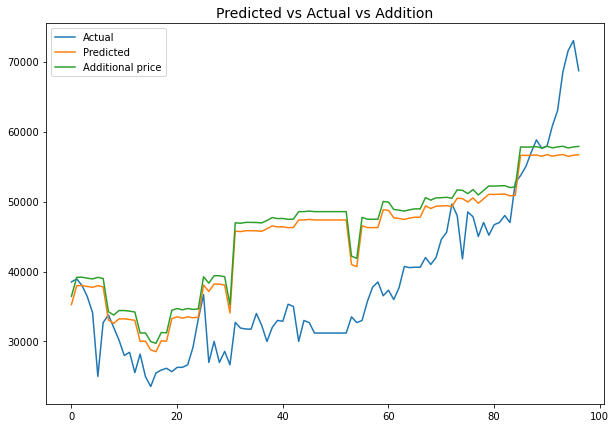

In [13]:
# Plotting the graph with the new increments
plot_new_pred(lr_pred, lr_pred['premium'], lr_pred['LR_prediction'], 0.90)

In [15]:
# Getting the mean and std of the new prediction
mean, std = difference_table(lr_pred, 'premium', 'added_premium')

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df[col_predict] - df[col_actual]
/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)


In [16]:
# Creating a new df for mean and std of the new predictions
diff_df = pd.DataFrame(columns=['Model',
                                'Average difference',
                                'Standard Deviation',
                                ])

In [17]:
# Adding the mean and std of the lr model
diff_df.loc[1] = ['Linear Regression',
                  mean,
                  std]

diff_df

,Model,Average difference,Standard Deviation
1,Linear Regression,8830.4,5205.9


## Multivariate Linear Regression Model

For this model, it is the opposite as it is already at 100% success rate.

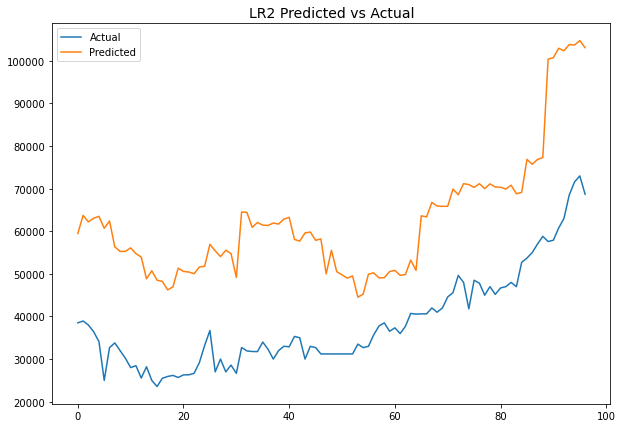

In [20]:
plt.figure(figsize=(10,7))
plt.plot(lr2_pred['premium'], label='Actual')
plt.plot(lr2_pred['LR2_prediction'], label='Predicted')
plt.title('LR2 Predicted vs Actual', fontsize=14)
plt.legend();

While the model has a 100% success rate, the model over predicts the premium price for each prediction. This will result in an unnecessarily high price package to the customers and will not be competitive to the market. Hence there is a need to lower the predictions instead.

In [21]:
# Creating a function to deduct from the prediction instead.
def success_with_subtraction(actual_premium, predicted_premium, success_rate):
    current_rate = 1
    subtraction = 0
    while current_rate > success_rate:
        successful_bids = []
        new_preds = predicted_premium - subtraction
        for i in range(len(new_preds)):
            if new_preds[i] >= actual_premium[i]:
                successful_bids.append(new_preds[i])
        current_rate = (len(successful_bids) / len(actual_premium))
        subtraction += 1
    return subtraction, current_rate

In [22]:
# Calculating the deduction to minus from the predictions.
success_with_subtraction(lr2_pred['premium'], lr2_pred['LR2_prediction'], .9)

(14011, 0.8969072164948454)

In [23]:
# Creating a new column for the new predictions
lr2_pred['minus_premium'] = lr2_pred['LR2_prediction'] - 14011

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2619963245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr2_pred['minus_premium'] = lr2_pred['LR2_prediction'] - 14011


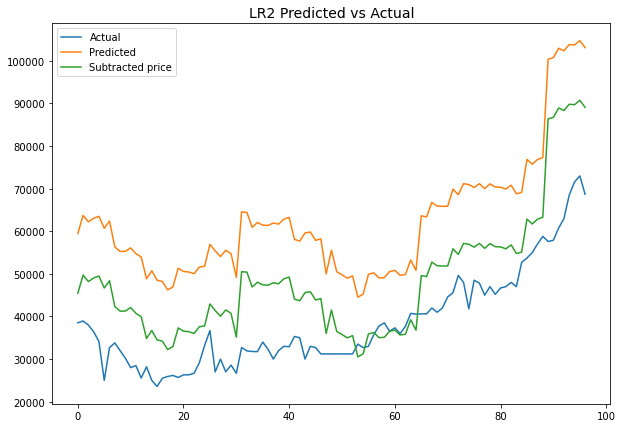

In [24]:
# Plotting the graph with the new deductions
plt.figure(figsize=(10,7))
plt.plot(lr2_pred['premium'], label='Actual')
plt.plot(lr2_pred['LR2_prediction'], label='Predicted')
plt.plot(lr2_pred['minus_premium'], label='Subtracted price')
plt.title('LR2 Predicted vs Actual', fontsize=14)
plt.legend();

In [25]:
# Getting the mean and std of the new prediction
mean2, std2 = difference_table(lr2_pred, 'premium', 'minus_premium')

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df[col_predict] - df[col_actual]
/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)


In [26]:
# Adding the mean and std of the lr2 model
diff_df.loc[2] = ['Linear Regression 2',
                  mean2,
                  std2]

diff_df

,Model,Average difference,Standard Deviation
1,Linear Regression,8830.4,5205.9
2,Linear Regression 2,11499.5,5687.4


## RNN models

I will be apply the same function to each model to calculate the increments need to raise the success rate of each model to 90%.

In [27]:
predictions2

,premium,LSTM_Prediction,GRU_Predictions,GRU_Multi_Predictions,GRU_Multi2_Predictions,GRU_Multi3_Predictions
0,26170.0,28209.459,26900.830,25025.610750,22962.083831,24331.044759
1,25689.0,27569.479,27400.701,25585.089153,23203.277357,25115.272985
2,26301.0,27106.443,27281.145,25295.396172,22835.124774,24988.515666
3,26309.0,26771.682,27505.580,25378.877266,22862.297644,25112.907024
4,26659.0,26542.412,27665.110,25548.449695,23181.739427,24957.025329
...,...,...,...,...,...,...
74,63000.0,56974.266,62398.953,58574.948079,55427.325225,58025.309549
75,68501.0,58305.750,64817.832,60930.830371,57856.387622,60392.851471
76,71556.0,59982.770,69614.690,65041.327971,62018.650911,64339.010851
77,72996.0,61717.140,73027.790,68108.217211,64938.696866,67788.065914


In [28]:
# Separating the df to each particular model
gru_uni = predictions2[['premium', 'GRU_Predictions']]
gru_multi_1 = predictions2[['premium', 'GRU_Multi_Predictions']]
gru_multi_2 = predictions2[['premium', 'GRU_Multi2_Predictions']]
gru_multi_3 = predictions2[['premium', 'GRU_Multi3_Predictions']]

In [29]:
gru_uni

,premium,GRU_Predictions
0,26170.0,26900.830
1,25689.0,27400.701
2,26301.0,27281.145
3,26309.0,27505.580
4,26659.0,27665.110
...,...,...
74,63000.0,62398.953
75,68501.0,64817.832
76,71556.0,69614.690
77,72996.0,73027.790


In [54]:
# Calculating the increment to add to the predictions.
success_with_addition(gru_uni['premium'], gru_uni['GRU_Predictions'], 0.90)

(1943, 0.9113924050632911)

You should add $1943 to your predictions to achieve a 91.1% accuracy


/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2343468246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['added_premium'] = predicted_premium + addition


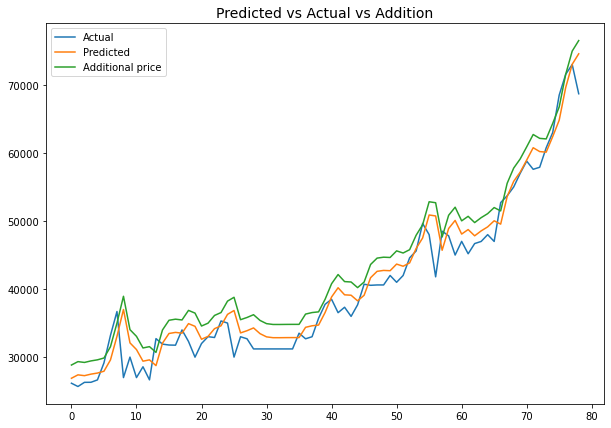

In [35]:
# Plotting the graph with the new increments
plot_new_pred(gru_uni, gru_uni['premium'], gru_uni['GRU_Predictions'], 0.90)

In [39]:
# Getting the mean and std of the new prediction
mean3, std3 = difference_table(gru_uni, 'premium', 'added_premium')

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df[col_predict] - df[col_actual]
/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)


In [40]:
# Adding the mean and std of the GRU model
diff_df.loc[3] = ['GRU - Univariate',
                  mean3,
                  std3]

diff_df

,Model,Average difference,Standard Deviation
1,Linear Regression,8830.4,5205.9
2,Linear Regression 2,11499.5,5687.4
3,GRU - Univariate,3558.0,2133.1


## GRU Multi 1

In [41]:
# Calculating the increment to add to the predictions.
success_with_addition(gru_multi_1['premium'], gru_multi_1['GRU_Multi_Predictions'], 0.90)

(4889, 0.9113924050632911)

You should add $4889 to your predictions to achieve a 91.1% accuracy


/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2343468246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['added_premium'] = predicted_premium + addition


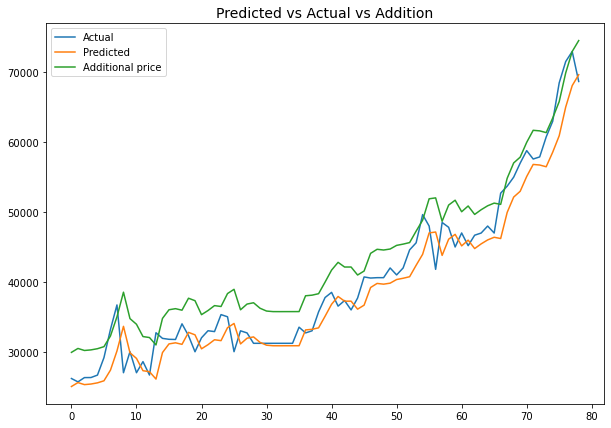

In [43]:
# Plotting the graph with the new increments
plot_new_pred(gru_multi_1, gru_multi_1['premium'], gru_multi_1['GRU_Multi_Predictions'], 0.90)

In [44]:
# Getting the mean and std of the new prediction
mean4, std4 = difference_table(gru_multi_1, 'premium', 'added_premium')

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df[col_predict] - df[col_actual]
/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)


In [45]:
# Adding the mean and std of the multivariate gru model
diff_df.loc[4] = ['GRU - Multivariate 1',
                  mean4,
                  std4]

diff_df

,Model,Average difference,Standard Deviation
1,Linear Regression,8830.4,5205.9
2,Linear Regression 2,11499.5,5687.4
3,GRU - Univariate,3558.0,2133.1
4,GRU - Multivariate 1,3849.1,2134.4


## GRU Multi 2

You should add $7636 to your predictions to achieve a 91.1% accuracy


/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2343468246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['added_premium'] = predicted_premium + addition


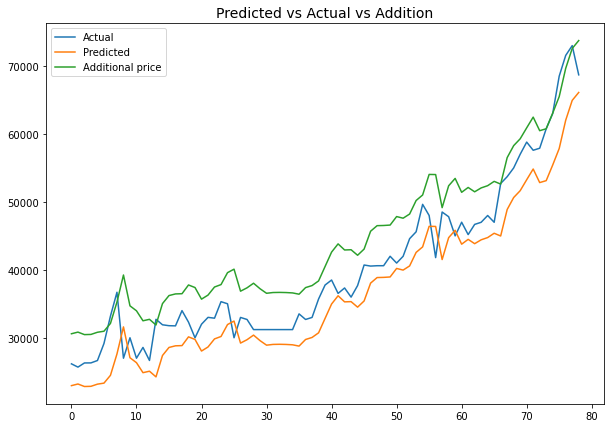

In [46]:
# Plotting the graph with the new increments
plot_new_pred(gru_multi_2, gru_multi_2['premium'], gru_multi_2['GRU_Multi2_Predictions'], 0.90)

In [47]:
# Getting the mean and std of the new prediction
mean5, std5 = difference_table(gru_multi_2, 'premium', 'added_premium')

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df[col_predict] - df[col_actual]
/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)


In [48]:
# Adding the mean and std of the lr model
diff_df.loc[5] = ['GRU - Multivariate 2',
                  mean5,
                  std5]

diff_df

,Model,Average difference,Standard Deviation
1,Linear Regression,8830.4,5205.9
2,Linear Regression 2,11499.5,5687.4
3,GRU - Univariate,3558.0,2133.1
4,GRU - Multivariate 1,3849.1,2134.4
5,GRU - Multivariate 2,4738.3,2216.6


## GRU Multi 3

You should add $5209 to your predictions to achieve a 91.1% accuracy


/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2343468246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['added_premium'] = predicted_premium + addition


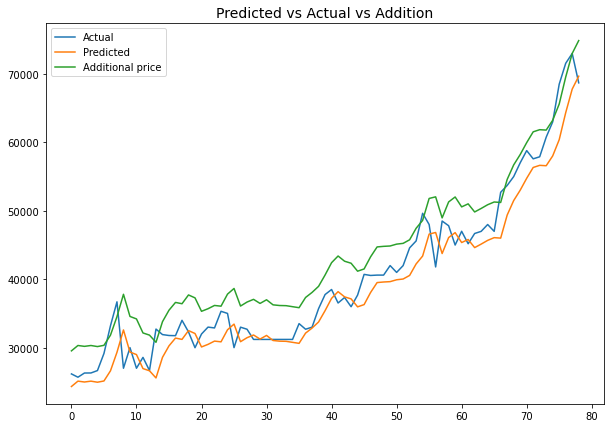

In [49]:
# Plotting the graph with the new increments
plot_new_pred(gru_multi_3, gru_multi_3['premium'], gru_multi_3['GRU_Multi3_Predictions'], 0.90)

In [51]:
# Getting the mean and std of the new prediction
mean6, std6 = difference_table(gru_multi_3, 'premium', 'added_premium')

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df[col_predict] - df[col_actual]
/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_84146/2258427524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['success'] = df['difference'].map(lambda x: 1 if x >=0 else 0)


In [52]:
# Adding the mean and std of the lr model
diff_df.loc[6] = ['GRU - Multivariate 3',
                  mean6,
                  std6]

diff_df

,Model,Average difference,Standard Deviation
1,Linear Regression,8830.4,5205.9
2,Linear Regression 2,11499.5,5687.4
3,GRU - Univariate,3558.0,2133.1
4,GRU - Multivariate 1,3849.1,2134.4
5,GRU - Multivariate 2,4738.3,2216.6
6,GRU - Multivariate 3,3892.5,2142.2


## Conclusion and Recommendation

According to our goal, I want a model with a low MSE and a high success rate. However, as success rates can be adjusted, I include a new metric which was the average difference and std of the difference to actual premiums. 

Having a low average difference to the actual coe premiums would allow for us to be competitive in the market while having a low standard deviate would allow us to have consistent earnings.

Hence, the model that was eventually selected was the Univariate GRU model as it has the lowest MSE and at the same success rate with other models, it has the lowest difference and std to the actual premiums.

### Other areas for future exploration:

CEO has a 10 year lifespan, which means that there should be a seasonality of around 10 years. However, as there are only 20 years worth of data, it is hard for the model to pick up the seasonality. Once there are sufficient data points, I would like to explore futher if a SARIMA model will be able to work as well.

As a add on to the model, I would like to be able to predict for more than just the next bidding exercise. If the model is able to predict for 2 - 3 months ahead, the company will be able to price the COE packages accordingly and advice customers if there is an upward or downward trend in the COE premiums.

## In my next notebook, I will be attempting to predict the premium for the 1st bidding exercise of May 2022.